In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

df = pd.read_csv('data/final_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            2792 non-null   int64  
 1   concept_1             2792 non-null   object 
 2   concept_2             2792 non-null   object 
 3   colexification_count  2792 non-null   int64  
 4   age_acquisition_diff  2792 non-null   float64
 5   assoc                 2792 non-null   float64
 6   Word2Vec_similarity   2792 non-null   float64
 7   concreteness_diff     2792 non-null   float64
 8   concreteness_1        2792 non-null   float64
 9   concreteness_2        2792 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 218.2+ KB


In [7]:
df['target'] = np.where(df['colexification_count'] > 1, 1, 0)
df.to_csv('data/final_dataset.csv', index=False)

In [8]:
from scipy.stats import spearmanr

df_spearman1 = df[['Word2Vec_similarity', 'assoc', 'concreteness_diff', 'age_acquisition_diff']]
for col in df_spearman1.columns:
    print(col)
    print(spearmanr(df[col], df['colexification_count']))
    print()

Word2Vec_similarity
SpearmanrResult(correlation=0.07021299285257003, pvalue=0.00020487161248081563)

assoc
SpearmanrResult(correlation=0.33071437030539547, pvalue=3.0534631642366944e-72)

concreteness_diff
SpearmanrResult(correlation=-0.132215156723664, pvalue=2.318494647119637e-12)

age_acquisition_diff
SpearmanrResult(correlation=-0.10134591003549194, pvalue=8.028868994385345e-08)



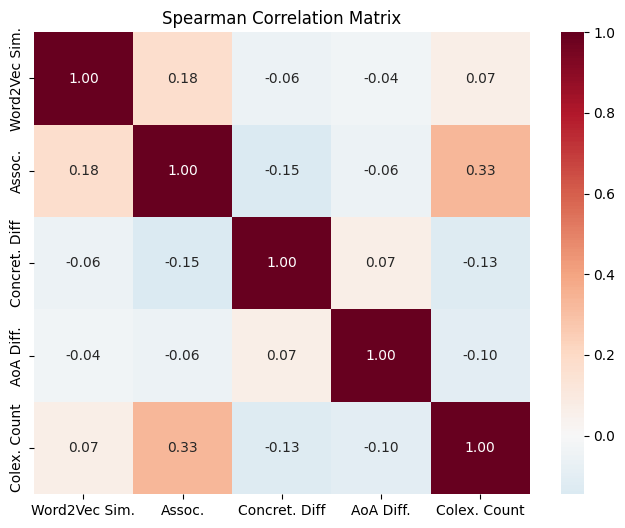

In [16]:
import seaborn as sns

df_spearman = df[['Word2Vec_similarity', 'assoc', 'concreteness_diff', 'age_acquisition_diff', 'colexification_count']]
corr_matrix = df_spearman.corr(method='spearman')

# change the label name in the corr_matrix
corr_matrix.index = ['Word2Vec Sim.', 'Assoc.', 'Concret. Diff', 'AoA Diff.', 'Colex. Count']
corr_matrix.columns = ['Word2Vec Sim.', 'Assoc.', 'Concret. Diff', 'AoA Diff.', 'Colex. Count']

# I want to adjust the size of the graph
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title('Spearman Correlation Matrix')

plt.savefig('result/spearman_correlation_matrix.png', dpi=300)
plt.show()

In [17]:
df_baseline = df[['Word2Vec_similarity', 'assoc', 'concreteness_diff', 'target']]
df_w_aoa = df[['Word2Vec_similarity', 'assoc', 'concreteness_diff', 'age_acquisition_diff', 'target']]

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_baseline = df_baseline.drop('target', axis=1)
y_baseline = df_baseline['target']
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_baseline, y_baseline, test_size=0.3, random_state=42)

X_w_aoa = df_w_aoa.drop('target', axis=1)
y_w_aoa = df_w_aoa['target']
X_train_aoa, X_test_aoa, y_train_aoa, y_test_aoa = train_test_split(X_w_aoa, y_w_aoa, test_size=0.3, random_state=42)

model_baseline = LogisticRegression()

model_baseline.fit(X_train_base, y_train_base)
baseline_predictions = model_baseline.predict(X_test_base)
baseline_report = classification_report(y_test_base, baseline_predictions)

model_aoa = LogisticRegression()

model_aoa.fit(X_train_aoa, y_train_aoa)
aoa_predictions = model_aoa.predict(X_test_aoa)
aoa_report = classification_report(y_test_aoa, aoa_predictions)

print("Baseline Model Report:\n", baseline_report)
print("Model with Age of Acquisition Difference Report:\n", aoa_report)

Baseline Model Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       623
           1       0.65      0.08      0.14       215

    accuracy                           0.75       838
   macro avg       0.71      0.53      0.50       838
weighted avg       0.73      0.75      0.67       838

Model with Age of Acquisition Difference Report:
               precision    recall  f1-score   support

           0       0.76      0.99      0.86       623
           1       0.68      0.09      0.16       215

    accuracy                           0.76       838
   macro avg       0.72      0.54      0.51       838
weighted avg       0.74      0.76      0.68       838



Word2Vec Sim.: 0.39842284491864705
Assoc.: 0.09480381093828827
Concret. Diff: -0.003246714999552799
AoA Diff.: -0.0037970573488265813


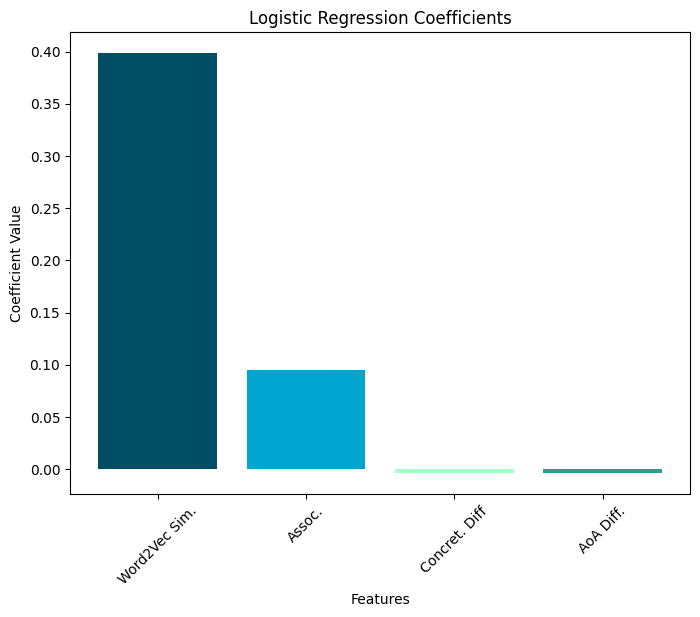

In [22]:
feature_names = ['Word2Vec Sim.', 'Assoc.', 'Concret. Diff', 'AoA Diff.']
coefficients = model_aoa.coef_[0]

for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

colors = ['#004e64', '#00a5cf', '#9fffcb', '#25a18e']

plt.figure(figsize=(8, 6))
plt.bar(feature_names, coefficients, color=colors)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.title('Logistic Regression Coefficients')
plt.savefig('result/logistic_regression_coefficients.png', dpi=300)
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


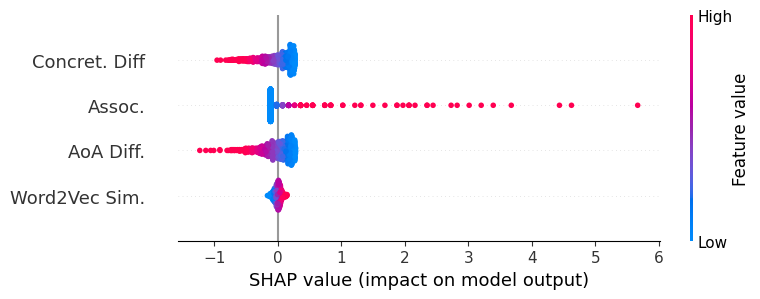

<Figure size 640x480 with 0 Axes>

In [34]:
import shap

explainer = shap.Explainer(model_aoa, X_train_aoa)

# Calculate SHAP values
shap_values = explainer(X_test_aoa)

feature_names = ['Word2Vec Sim.', 'Assoc.', 'Concret. Diff', 'AoA Diff.']
fig = shap.summary_plot(shap_values, X_test_aoa, feature_names=feature_names)

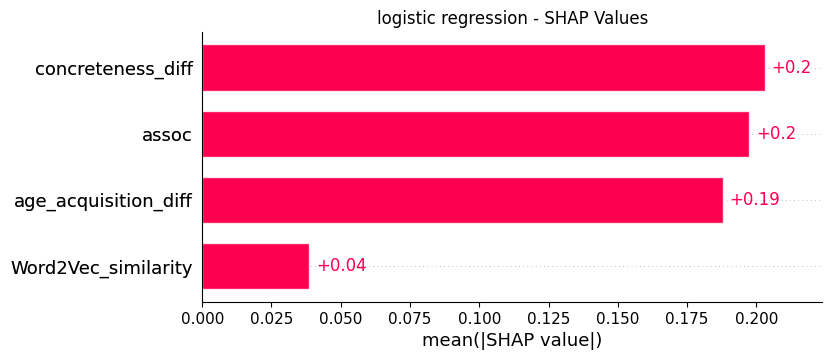

In [33]:
fig = shap.plots.bar(shap_values, max_display=34, show=False)
plt.title('logistic regression' + ' - SHAP Values')
plt.savefig('result/shap_bar_plot.png', dpi=300)
plt.show(fig)

In [35]:
from sklearn.model_selection import cross_val_score

def feature_predictions(df, features):
    accuracies = {}
    for feature in features:
        X = df[[feature]]
        y = df['target']
        model = LogisticRegression()
        accuracies[feature] = cross_val_score(model, X, y, cv=5).mean()
    X_all = df.drop('target', axis=1)
    y_all = df['target']
    model = LogisticRegression()
    accuracies['Combined'] = cross_val_score(model, X_all, y_all, cv=5).mean()
    return accuracies

Baseline Model Accuracies:
 {'Word2Vec_similarity': 0.7392553266521759, 'assoc': 0.7500028853367188, 'concreteness_diff': 0.7392553266521759, 'Combined': 0.7514365770929912}
Model with Age of Acquisition Difference Accuracies:
 {'Word2Vec_similarity': 0.7392553266521759, 'assoc': 0.7500028853367188, 'concreteness_diff': 0.7392553266521759, 'age_acquisition_diff': 0.7392553266521759, 'Combined': 0.7528670629195761}


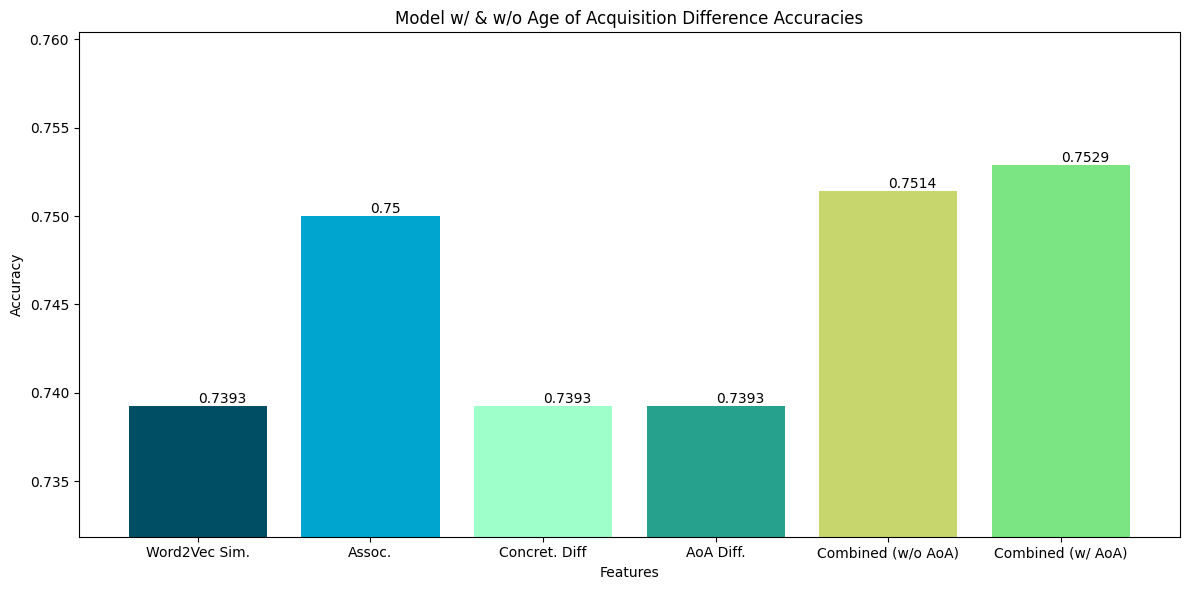

In [38]:
baseline_features = ['Word2Vec_similarity', 'assoc', 'concreteness_diff']
baseline_accuracies = feature_predictions(df_baseline, baseline_features)

# accuracies with age of acquisition difference
aoa_features = ['Word2Vec_similarity', 'assoc', 'concreteness_diff', 'age_acquisition_diff',]
aoa_accuracies = feature_predictions(df_w_aoa, aoa_features)

print("Baseline Model Accuracies:\n", baseline_accuracies)
print("Model with Age of Acquisition Difference Accuracies:\n", aoa_accuracies)

plot_accuracy = aoa_accuracies.copy()
plot_accuracy['Combined (w/o AoA)'] = baseline_accuracies.pop('Combined')
plot_accuracy['Combined (w/ AoA)'] = plot_accuracy.pop('Combined')

colors = ['#004e64', '#00a5cf', '#9fffcb', '#25a18e', '#c7d66d', '#7ae582']

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(plot_accuracy)), list(plot_accuracy.values()), align='center', color=colors)

feature_names = ['Word2Vec Sim.', 'Assoc.', 'Concret. Diff', 'AoA Diff.', 'Combined (w/o AoA)', 'Combined (w/ AoA)']

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 4), va='bottom')  # va: vertical alignment

plt.ylim(min(plot_accuracy.values())*0.99, max(plot_accuracy.values())*1.01)  # Small buffer above and below

plt.xticks(range(len(plot_accuracy)), list(feature_names))
plt.title('Model w/ & w/o Age of Acquisition Difference Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Features')

plt.tight_layout()
plt.savefig('result/model_accuracies.png', dpi=300)
plt.show()